# `NoEpistasis` model
Simulates some variants and analyzes them under the `globalepistasis.NoEpistasis` model.

This notebook is designed as a test, not for user documentation--and it uses some private methods that should not be used in real analyses.

## Set up
Import Python modules:

In [1]:
import math
import random
import warnings

import pandas as pd

from plotnine import *

import scipy

import dms_variants.binarymap
import dms_variants.globalepistasis
import dms_variants.codonvarianttable
import dms_variants.plotnine_themes
import dms_variants.simulate
from dms_variants.constants import CBPALETTE, CODONS_NOSTOP

Parameters for simulations:

In [2]:
seed = 1  # random number seed
genelength = 500  # gene length in codons
bclen = 16  # length of barcodes
libs = ['lib_1', 'lib_2']  # distinct libraries of gene
variants_per_lib = 500 * genelength  # variants per library
avgmuts = 2.5  # average codon mutations per variant
variant_error_rate = 0  # rate variants are mis-sequenced
depth = 1000 * variants_per_lib  # per-sample sequencing depth
lib_uniformity = 5  # uniformity of library pre-selection
noise = 0.0  # non-statistical noise in selections
bottlenecks = {  # bottlenecks from pre- to post-selection
        'tight_bottle': variants_per_lib * 5,
        'loose_bottle': variants_per_lib * 1000,
        }

Seed random number generators:

In [3]:
random.seed(seed)
scipy.random.seed(seed)

Suppress warnings that clutter output:

In [4]:
warnings.simplefilter('ignore')

Set plotnine theme:

In [5]:
theme_set(dms_variants.plotnine_themes.theme_graygrid())

## Simulate variants
Simulate wildtype gene sequence:

In [6]:
geneseq = ''.join(random.choices(CODONS_NOSTOP, k=genelength))
print(f"Wildtype gene of {genelength} codons:\n{geneseq}")

Wildtype gene of 500 codons:
AGATCCGTGATTCTGCGTGCTTACACCAACTCACGGGTGAAACGTGTAATCTTATGCAACAACGACTTACCTATCCGCAACATCCGGCTGATGATGATCCTACACAACTCCGACGCTAGTTTTTCGACTCCAGTAGGTTTACGCTCAGGACAGGATTCTTCCCTGGATAAGATGTACCGCAGGGACGGGGGCCCGCGGCTTGTTCTTCCTCTCAACAAGGGGTTGGCACGAAGGCTGTTGGTTGAATCGATGCTTTTCGATCTACAAGACTTCAAAGTTTCATGCGTCTATCTTGAGCGCAATTCTGAGATACTGCTCCCCCCCGAAGCGGCCCGTAACATGAGGGATTCGTACTACTATATTTCCGGCACCAACAAAGTGATTACGGCGCCCACAAGCGAAAGGCAAGGTCGTCATCTAAACCCTCGCAGTACGTGCCTTATAGCATATAACAACAGAGGTAGCGGGGGCGACATCTTGTACCTTATCGCTCGAGATCATGCGAATCAGTTGTCTCAGTCGCAGTTAGTCCGCATTAAATCTAAGTATTTCGAGAGGTCGTTGGGGCTTCCTCCCATAGGCCGGAGTACGGGACAGCTGCATTCTTGCAACATACATTTTGTTCCAATAGGCTCCTGTCCATCTGGCCTCTTTATGGTAACCAGGTGGATAGTGGCATCCCCGCCACACTCGGCATTCTGCAGAGACACGAAGACATCGTACTCACCAGCCGTTCCTGAGATCACACAATGCGAGTGTCGTCAATACTCAAAAGGAACCACTTCTAAGATGTTTCGCACTAGGATGGTCACGTGGCCTTTGTGGCACATTCTCACGGCTAAGAAATTGCAGGCACGTCATAATTGGTTGTTGACGATCGCCTTGGACGGCGGAATTGACCAGATTACACACTTGCGTGCTGCTTTACCTCAGCATCATTCCTGCCAGCCAGACGATGCAATGAACATGAC

Simulate a `CodonVariantTable`:

In [7]:
variants = dms_variants.simulate.simulate_CodonVariantTable(
                geneseq=geneseq,
                bclen=bclen,
                library_specs={lib: {'avgmuts': avgmuts,
                                     'nvariants': variants_per_lib}
                               for lib in libs},
                seed=seed,
                )

Number of amino-acid mutations per variant in library:

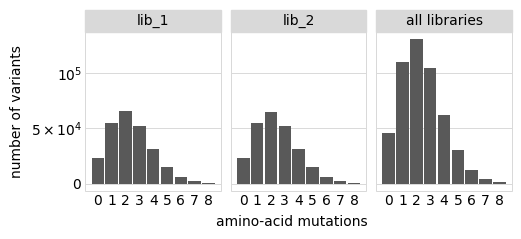

In [8]:
p = variants.plotNumMutsHistogram('aa', samples=None, max_muts=8)
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

## Simulate variants
We will simulate using a `SigmoidPhenotypeSimulator`:

In [9]:
phenosimulator = dms_variants.simulate.SigmoidPhenotypeSimulator(
                    geneseq,
                    seed=seed,
                    norm_weights=((0.4, -0.5, 0.7), (0.6, -5, 1.5)),
                    )

But since we are using a non-epistatic (linear model), we will simulate variants according to the *latent phenotype* rather than their *observed phenotype* (since in a non-epistatic model these two are the same).
First, look at the distribution of latent phenotypes for all single mutants (the dashed orange line is the latent phenotype of wildtype):

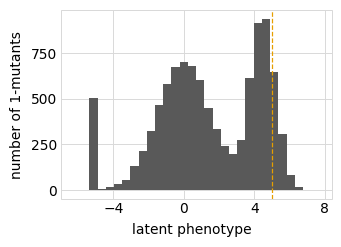

In [10]:
p = phenosimulator.plotMutsHistogram('latent')
_ = p.draw()

Our simulation function is then the exponential of the latent phenotype, as mutants as the functional scores represent the log enrichment:

In [11]:
def phenotype_func(x):
    return math.exp(phenosimulator.latentPhenotype(x))

Now we simulate the counts, passing to the simulate function the latent rather than observed phenotype:

In [12]:
counts = dms_variants.simulate.simulateSampleCounts(
            variants=variants,
            phenotype_func=phenotype_func,
            variant_error_rate=variant_error_rate,
            pre_sample={'total_count': depth,
                        'uniformity': lib_uniformity},
            pre_sample_name='pre-selection',
            post_samples={name: {'noise': noise,
                                 'total_count': depth,
                                 'bottleneck': bottle}
                          for name, bottle in bottlenecks.items()},
            seed=seed,
            )

Add the counts to the variant table:

In [13]:
variants.add_sample_counts_df(counts)

Confirm expected selection on mutations:

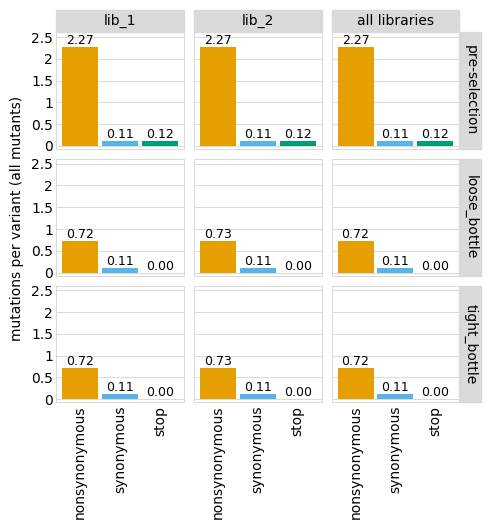

In [14]:
p = variants.plotNumCodonMutsByType('all')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

In [15]:
variants.numCodonMutsByType('all')

,library,sample,mutation_type,num_muts_count,count,number
0,lib_1,pre-selection,nonsynonymous,567620205,250000000,2.270481
1,lib_1,pre-selection,synonymous,27323790,250000000,0.109295
2,lib_1,pre-selection,stop,29862642,250000000,0.119451
3,lib_1,loose_bottle,nonsynonymous,178888080,250000000,0.715552
4,lib_1,loose_bottle,synonymous,27406414,250000000,0.109626
5,lib_1,loose_bottle,stop,1340,250000000,0.000005
6,lib_1,tight_bottle,nonsynonymous,179342833,250000000,0.717371
7,lib_1,tight_bottle,synonymous,27168988,250000000,0.108676
8,lib_1,tight_bottle,stop,1312,250000000,0.000005
9,lib_2,pre-selection,nonsynonymous,567016164,250000000,2.268065


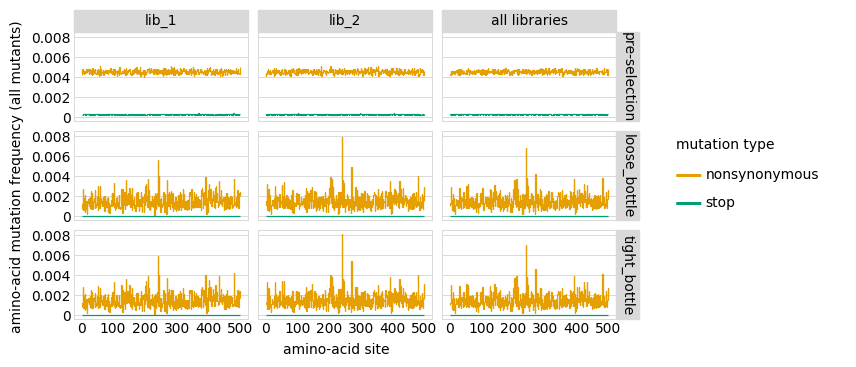

In [16]:
p = variants.plotMutFreqs('all', 'aa')
p = p + theme(panel_grid_major_x=element_blank())  # no vertical grid lines
_ = p.draw()

## Get functional scores
Get the functional scores:

In [17]:
func_scores = variants.func_scores('pre-selection', libraries=variants.libraries)

Classify the functional scores:

In [18]:
func_scores = variants.classifyVariants(func_scores)

Use `plotnine` to plot distribution of functional scores:

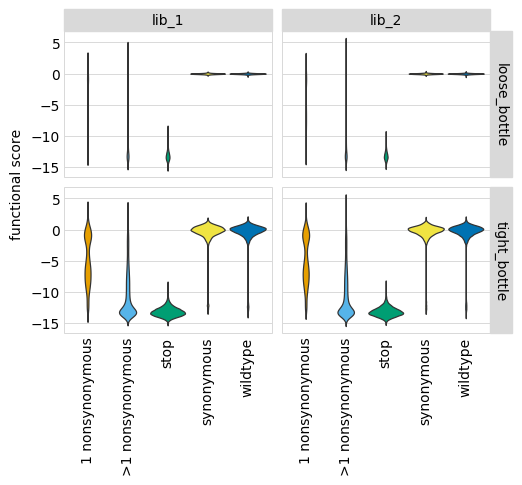

In [19]:
p = (
    ggplot(func_scores, aes('variant_class', 'func_score')) +
    geom_violin(aes(fill='variant_class')) +
    ylab('functional score') +
    xlab('') +
    facet_grid('post_sample ~ library') +
    theme(figure_size=(2.75 * len(libs),
                       2 * len(bottlenecks)),
          axis_text_x=element_text(angle=90),
          panel_grid_major_x=element_blank(),  # no vertical grid lines
          ) +
    scale_fill_manual(values=CBPALETTE[1 :], guide=False)
    )
_ = p.draw()

## Initialize `NoEpistasis` model

Focus just on loose bottleneck for now:

In [20]:
func_scores = func_scores.query('post_sample == "loose_bottle"')

Make a binary map for the variants:

In [21]:
binarymap = dms_variants.binarymap.BinaryMap(func_scores)
print(f"Length of binary map is {binarymap.binarylength}")

Length of binary map is 10000


Now initialize the `NoEpistasis` model:

In [22]:
noepistasis_model = dms_variants.globalepistasis.NoEpistasis(binarymap)

Look at some model attributes:

In [23]:
noepistasis_model.nparams

10002

In [24]:
noepistasis_model.epistasis_HOC

1.0

In [25]:
noepistasis_model.loglik

-8884261.462878693

In [26]:
noepistasis_model.latent_phenotype_wt

0.0

Check the analytical gradient versus numerical approximation, and make sure the difference is small compared to total gradient:

err = scipy.optimize.check_grad(
            noepistasis_model._loglik_by_allparams,
            noepistasis_model._dloglik_by_allparams,
            noepistasis_model._allparams)
tot = math.sqrt(sum(noepistasis_model._dloglik_by_allparams(noepistasis_model._allparams)**2))
if err / tot > 1e-5:
    raise ValueError(f"Numerical and analytical gradients differ: {err}, {tot}, {err / tot}")

## Initial least squares fitting

In [27]:
noepistasis_model._fit_latent_leastsquares()

err = scipy.optimize.check_grad(
            noepistasis_model._loglik_by_allparams,
            noepistasis_model._dloglik_by_allparams,
            noepistasis_model._allparams)
tot = math.sqrt(sum(noepistasis_model._dloglik_by_allparams(noepistasis_model._allparams)**2))
if err / tot > 1e-3:
    raise ValueError(f"Numerical and analytical gradients differ: {err}, {tot}, {err / tot}")

In [28]:
noepistasis_model.loglik

-1199136.7582622953

In [29]:
scipy.stats.pearsonr(
        binarymap.func_scores,
        noepistasis_model.latent_phenotypes_frombinary(binarymap.binary_variants),
        )

(0.839070798754724, 0.0)

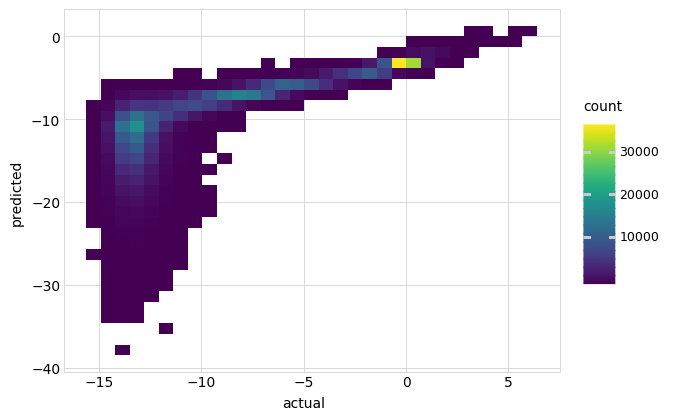

<ggplot: (8767376637027)>

In [30]:
import pandas as pd
df = pd.DataFrame({'actual': binarymap.func_scores,
                   'predicted': noepistasis_model.latent_phenotypes_frombinary(binarymap.binary_variants),
                   })

(ggplot(df, aes('actual', 'predicted')) +
 geom_bin2d()
 )

In [31]:
noepistasis_model.epistasis_HOC

5.713726321490428

In [32]:
noepistasis_model.latent_phenotype_wt

-3.1876397071114826

In [33]:
import time
start = time.time()
optres = noepistasis_model.fit(use_grad=True)
print(f"Fitting took {time.time() - start}")

Fitting took 23.494038105010986


In [34]:
noepistasis_model.loglik

-1189177.6976448842

In [35]:
noepistasis_model.epistasis_HOC

4.56784337504431

In [36]:
noepistasis_model.latent_phenotype_wt

-2.448717028223831

In [37]:
scipy.stats.pearsonr(
        binarymap.func_scores,
        noepistasis_model.latent_phenotypes_frombinary(binarymap.binary_variants),
        )

(0.8385038581484459, 0.0)

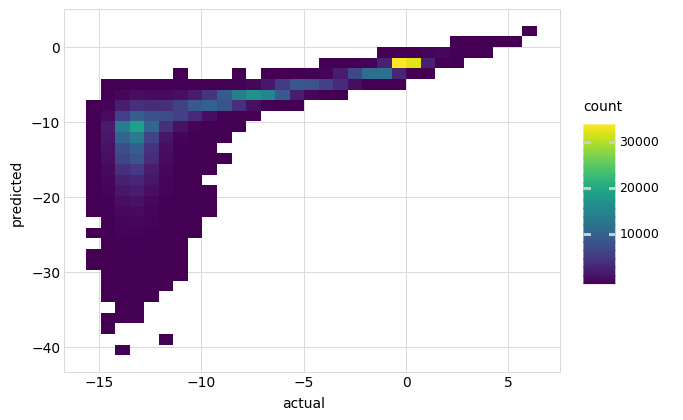

<ggplot: (8767376638142)>

In [38]:
import pandas as pd
df = pd.DataFrame({'actual': binarymap.func_scores,
                   'predicted': noepistasis_model.latent_phenotypes_frombinary(binarymap.binary_variants),
                   })

(ggplot(df, aes('actual', 'predicted')) +
 geom_bin2d()
 )

In [39]:
import sympy

In [40]:
pi, sigma2, y, mu, x = sympy.symbols('pi sigma2 y mu x')
N = (1 / sympy.sqrt(2 * pi * (sigma2 + x))) * sympy.exp(-(y - mu)**2 / (2 * (sigma2 + x)))
logN = sympy.ln(N)
logN

log(sqrt(2)*exp(-(-mu + y)**2/(2*sigma2 + 2*x))/(2*sqrt(pi*(sigma2 + x))))

In [41]:
sympy.simplify(sympy.diff(logN, sigma2))

(-sigma2 - x + (mu - y)**2)/(2*(sigma2 + x)**2)

In [42]:
(mu - y)**2 == (mu - y)**2

True

In [43]:
(3.2 - 1.5)**2

2.8900000000000006

In [44]:
(1.5 - 3.2)**2

2.8900000000000006

 ```    fun: 117882.93902758576
 hess_inv: <1002x1002 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.01600711, -0.03783498, -0.0174623 , ..., -0.01455192,
       -2.37778295, -0.14551915])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 29087
      nit: 23
   status: 0
  success: True
        x: array([-4.27544636, -4.39512549, -0.81036386, ..., -0.98913861,
       -2.38306556,  4.3093928 ])
       ```

In [45]:
optres

      fun: 1189177.6976448842
 hess_inv: <10002x10002 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.09867922,  0.01279784,  0.02730222, ..., -0.03653539,
       -7.70459282, -5.34798976])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 88
      nit: 74
   status: 0
  success: True
        x: array([-5.30513826, -4.38996048, -0.96413687, ..., -3.56436386,
       -2.44871703,  4.56784338])